# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs_f0 = load_data(data_dir, star_file, True)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  4.794729948043823
load_data: FFT of data, time:  8.017106056213379


In [4]:
print(imgs_f0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs_f = imgs_f0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Create the grids

In [7]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [8]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [9]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


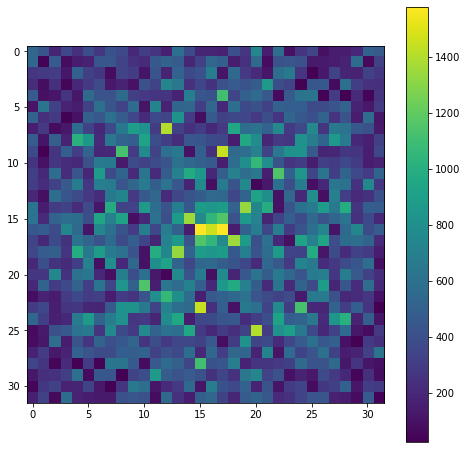

In [10]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

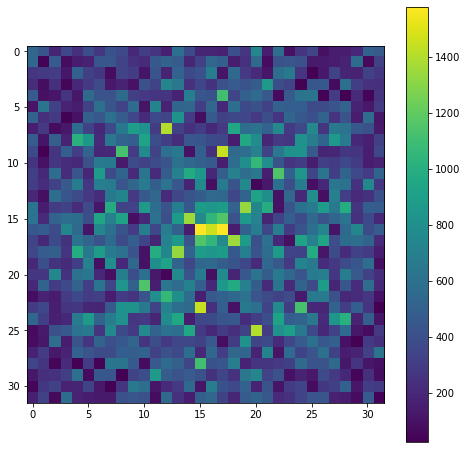

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

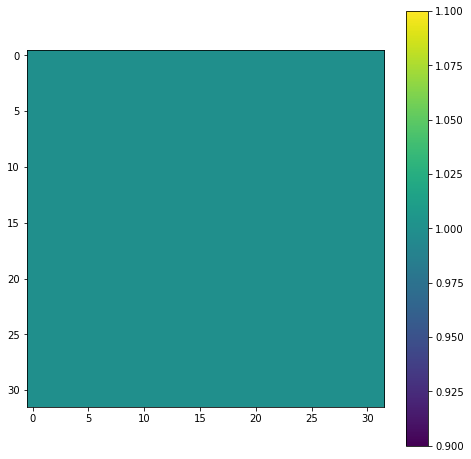

In [12]:
centre = (0,0,0)
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [13]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [14]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [15]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.5097198486328125
(32, 32, 32)


In [16]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.7878351211547852
(32, 32, 32)


### Ab initio

In [17]:
x_grid[0]*x_grid[1]/2

0.05021972132474

In [18]:
x_grid[0]

0.00313873258279625

  sgd epoch 0: mean sampled gradient = 0.00017270783014626206
  sgd epoch 50: mean sampled gradient = 1.2753883722020056e-06
  sgd epoch 100: mean sampled gradient = 5.448923482373362e-06
  sgd epoch 150: mean sampled gradient = 1.396862592865409e-05


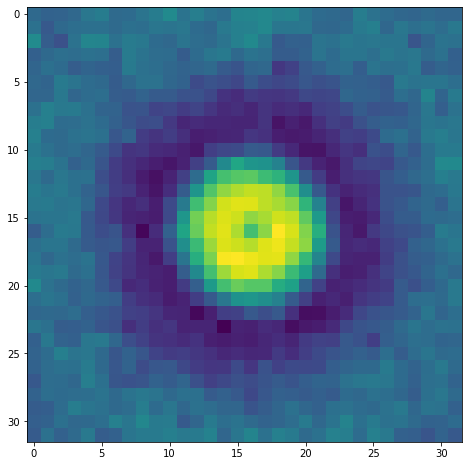

Iter  0
  Time orientations sampling = 1.8130648136138916
  sgd epoch 0: mean sampled gradient = 0.03127253128640033
  sgd epoch 50: mean sampled gradient = 0.00018441329928244686
  sgd epoch 100: mean sampled gradient = 0.0003868430695718617
  sgd epoch 150: mean sampled gradient = 0.00030346219372908627
  Time vol optimisation = 7.601716995239258
  nx = 8
  learning_rate = 1000


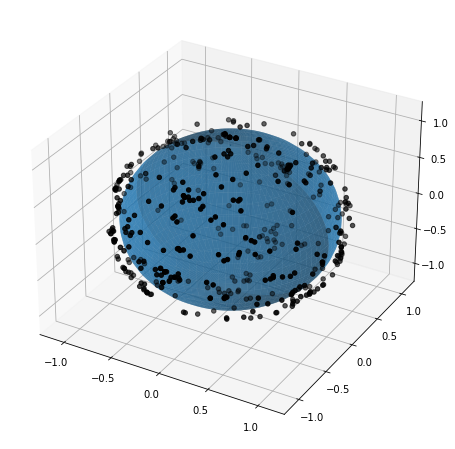

Iter  1
  Time orientations sampling = 1.751105546951294
  sgd epoch 0: mean sampled gradient = 0.007429747737291514
  sgd epoch 50: mean sampled gradient = 5.320101360689084e-06
  sgd epoch 100: mean sampled gradient = 3.788206867025977e-05
  sgd epoch 150: mean sampled gradient = 0.00010295153857664438
  Time vol optimisation = 11.352294921875
Iter  2
  Time orientations sampling = 1.7782361507415771
  sgd epoch 0: mean sampled gradient = 0.007696624375643009
  sgd epoch 50: mean sampled gradient = 6.780046618389591e-05
  sgd epoch 100: mean sampled gradient = 0.00019014443028209563
  sgd epoch 150: mean sampled gradient = 0.0002502411937592934
  Time vol optimisation = 9.176867008209229
Iter  3
  Time orientations sampling = 1.7925617694854736
  sgd epoch 0: mean sampled gradient = 0.008135933654030364
  sgd epoch 50: mean sampled gradient = 0.00037112805932222517
  sgd epoch 100: mean sampled gradient = 9.426771824290243e-05
  sgd epoch 150: mean sampled gradient = 0.00059585418254

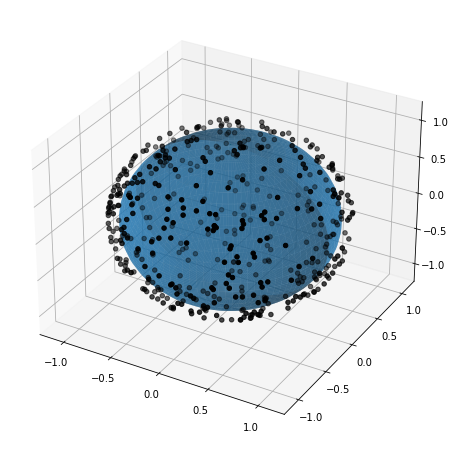

Iter  9
  Time orientations sampling = 1.783289909362793
  sgd epoch 0: mean sampled gradient = 0.0005228264964788662
  sgd epoch 50: mean sampled gradient = 1.1957966196125607e-05
  sgd epoch 100: mean sampled gradient = 0.00011674134882147424
  sgd epoch 150: mean sampled gradient = 6.0424176246488266e-05
  Time vol optimisation = 15.438129425048828
Iter  10
  Time orientations sampling = 1.8138563632965088
  sgd epoch 0: mean sampled gradient = 0.0007385287679355122
  sgd epoch 50: mean sampled gradient = 7.024372813142198e-05
  sgd epoch 100: mean sampled gradient = 0.00012149935505200246
  sgd epoch 150: mean sampled gradient = 8.138107621499743e-05
  Time vol optimisation = 14.8732750415802
Iter  11
  Time orientations sampling = 1.8103845119476318
  sgd epoch 0: mean sampled gradient = 0.0004964201180002102
  sgd epoch 50: mean sampled gradient = 0.00012541775332436454
  sgd epoch 100: mean sampled gradient = 9.511267404659257e-05
  sgd epoch 150: mean sampled gradient = 1.74890

In [ ]:
N_samples = 100000
N_iter = 100

dr = 0.005
radius = 0.01
#radius = 0.03
alpha = 1e-4 # or leave it 1e-6

use_sgd = True

N_cg_iter = 151

N_sgd_iter = 151
batch_size = 1000
#learning_rate = 1000
learning_rate = 1000
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])

v_rec, angles_rec = ab_initio(project, imgs_f, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, 'tri', True, True, True, out_dir)

In [ ]:
v_rec.shape

In [ ]:
plot_angles(angles_rec[:2000])

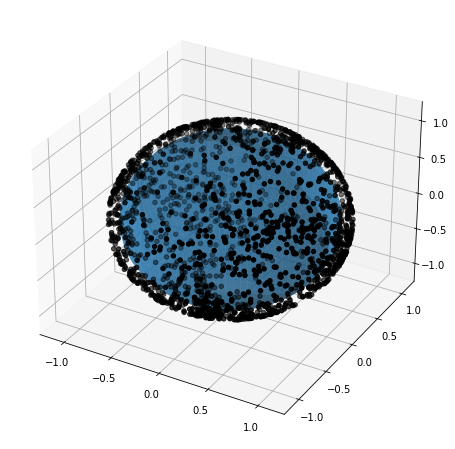

In [80]:
plot_angles(angles_rec[:2000])

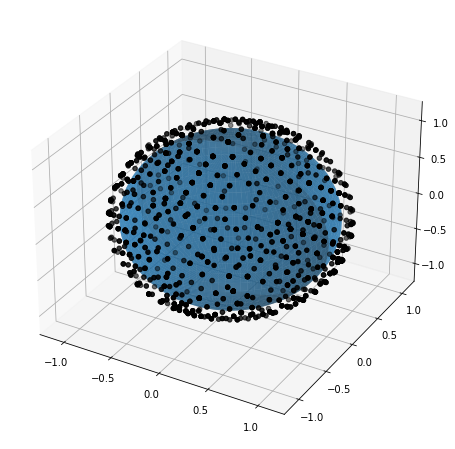

In [30]:
plot_angles(angles[:2000])

### CG

In [98]:
#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 151

N2 = jnp.floor(N/2).astype(jnp.int64)
#N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_rec[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape)

In [99]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.04894286225438528
  cg iter 50 ||r|| = 3.5441306341411475e-05
  cg iter 100 ||r|| = 1.2934660744538429e-05
  cg iter 150 ||r|| = 6.761631938431228e-06


In [100]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

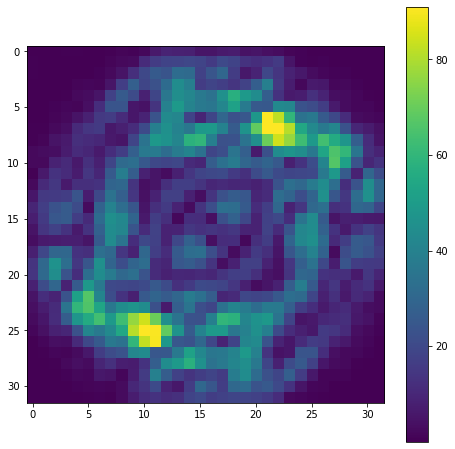

In [101]:
i = 110
s0 = slice_func(vcg1, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

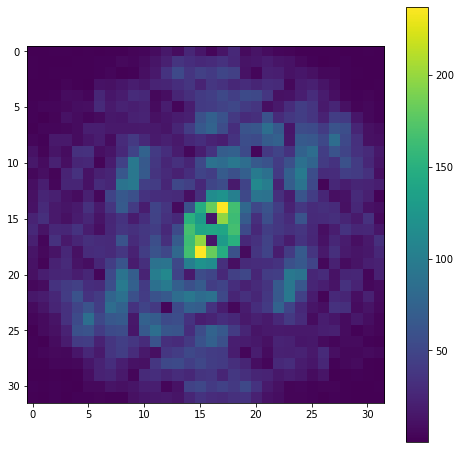

In [102]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

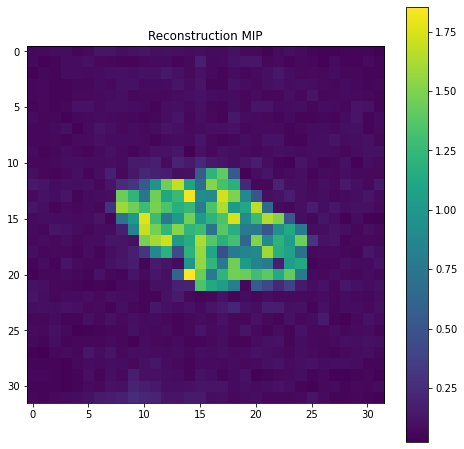

In [103]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [104]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

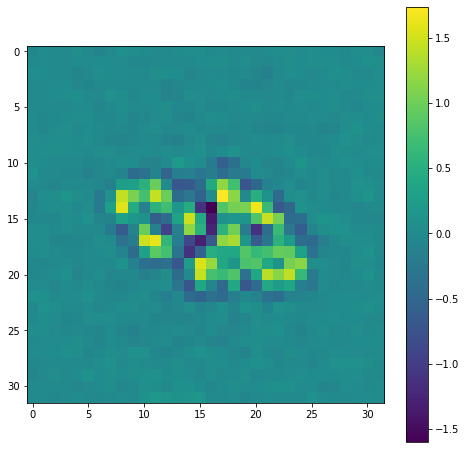

In [105]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

### Write volume to file

In [106]:
with mrcfile.new('../data/reconstruction_data_32_angles_rec.mrc', overwrite=True) as mrc:
    mrc.set_data(vr1.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


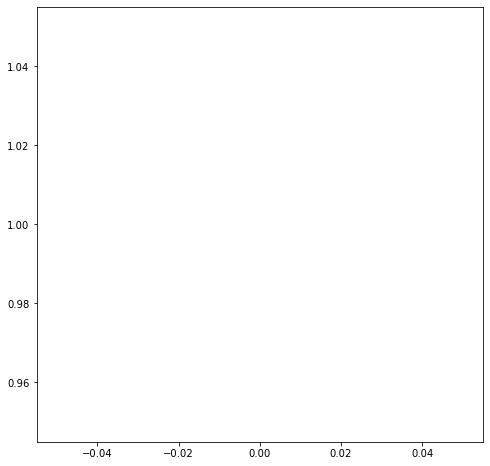

In [31]:
plt.plot(res,fsc)

In [17]:
#points_v_tri = points_orientations_tri(angles[:50], x_grid[1])
points_v_nn = points_orientations_nn(angles[:50], x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()

### SGD

### Preconditioner

0.001996007984031936
1.0


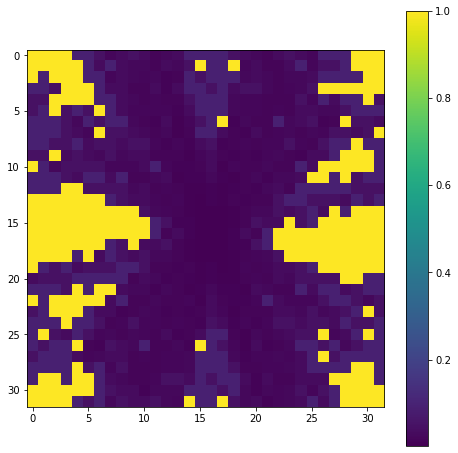

In [18]:
points_v_nn.shape
P = points_v_nn
P += 0.1
P = 1/P  * mask

P = P/jnp.max(P)

plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))

In [126]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = jnp.zeros([nx,nx,nx])* 1j

batch_size = 1000
N_epoch = 151
number_of_batches = N/batch_size
learning_rate = 10000
#learning_rate = 10000 # <- with normalized precon
P = None

sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_rec, shifts, ctf_params, imgs_f)
vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, verbose = True)
            
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vgd, angles, shifts, ctf_params, imgs_f)))
print("Relative error with CG = ", jnp.max(jnp.abs((vgd - vcg1)/jnp.max(vcg1))))

  sgd epoch 0: mean sampled gradient = 2.9519674558355862e-06
  sgd epoch 50: mean sampled gradient = 8.782730877631537e-06
  sgd epoch 100: mean sampled gradient = 2.643356966819453e-06
  sgd epoch 150: mean sampled gradient = 7.712670720294624e-07
Final loss function (over all data) =  118842.7851998627
Relative error with CG =  0.9413794127685574


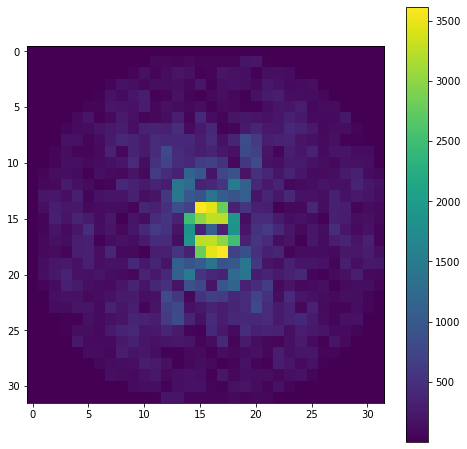

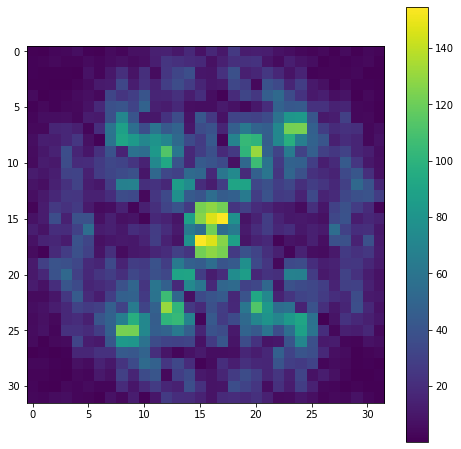

In [132]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgd[:,0,:]))); plt.colorbar()

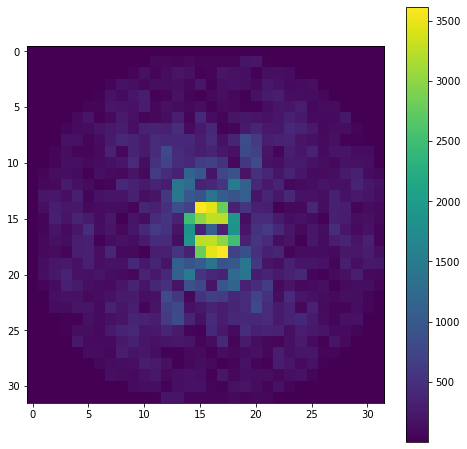

In [133]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

In [128]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd)))

Text(0.5, 1.0, 'Reconstruction MIP')

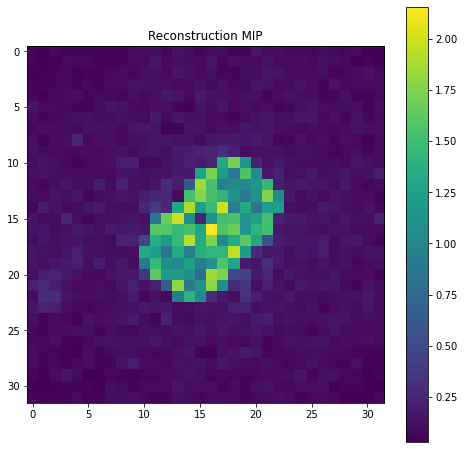

In [129]:
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

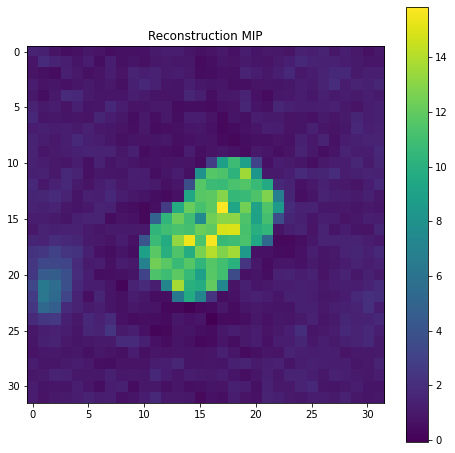

In [134]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [130]:
with mrcfile.new('../data/reconstruction_data_sgd.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))